In [1]:
import time

In [2]:
start_time = time.time()

In [3]:
from pathlib import Path
import cmasher as cmr
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import lmfit
import json
import pandas as pd
import corner
import sys

import astropy.units as u

sys.path.insert(1, 'C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules')  
import bplot_mod
import bfunc

In [4]:
data_in = json.load(open("data_ems_fluct.json"))

In [5]:
mask = np.array(data_in["sf"]["N pairs"]) > 0

In [6]:
B = np.array(data_in["sf"]["Unweighted B(r)"])[mask]
r = 10**np.array(data_in["sf"]["log10 r"])[mask]
box_size = 362
pc = 1
pix = 1
pc_per_arcsec = pc

In [7]:
model = lmfit.Model(bfunc.bfunc03s)
model.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
# Correlation length between 1/10 and 2 x box_size
model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2.0 * box_size)

# sig2 between 1/4 and 2 x max value of B(r)
model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B.max(), max=2.0 * B.max())

# m between 1/2 and 5/3
model.set_param_hint("m", value=1, min=0.5, max=1.5)

#Seeing RMS between 0.5 and 1.5 arcsec
#model.set_param_hint(
#    "s0", value=0.85 * pc_per_arcsec, min=0.5 * pc_per_arcsec, max=1.5 * pc_per_arcsec
#)

# Seeing pegged at ZERO
model.set_param_hint(
    "s0", value=0.0 * 1, vary=False,
)


# Noise cannot be much larger than smallest B(r)
model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())

# box_size is fixed
# model.set_param_hint("box_size", value=box_size, vary=False)

In [9]:
pd.DataFrame(model.param_hints)

,r0,sig2,m,s0,noise
value,36.20,0.173595,1.0,0,0.010022
min,3.62,0.086797,0.5,NaN,0.000000
max,724.00,0.694379,1.5,NaN,0.060133
vary,NaN,NaN,NaN,False,NaN


In [10]:
relative_uncertainty = 0.085
weights = 1.0 / (relative_uncertainty * B)
large_scale = r > 0.5* box_size
weights[large_scale] /= 2.0
#weights[:1] /= 2.0

In [11]:
to_fit = r <= 0.5* box_size
#to_fit = ~large_scale
result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

In [12]:
result

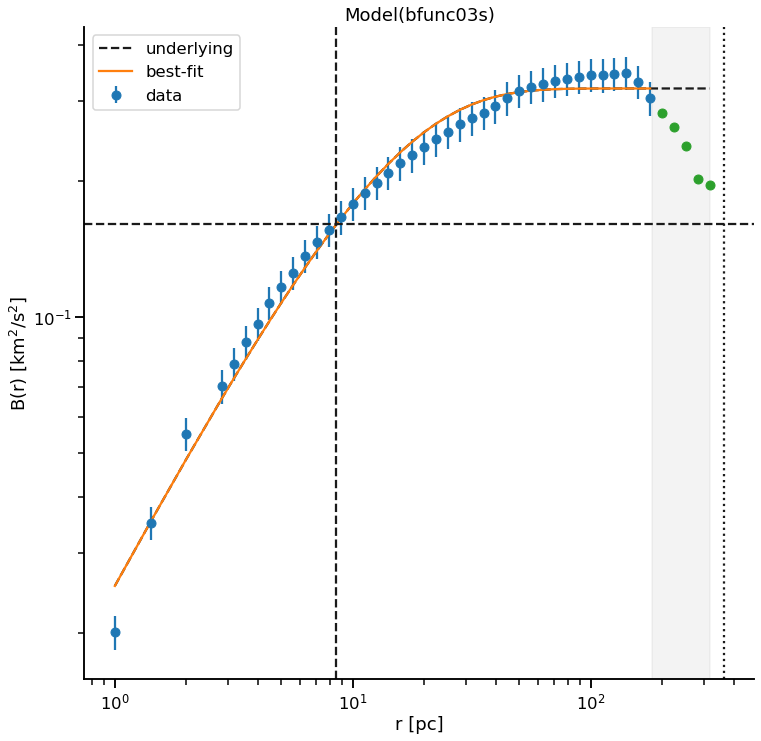

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the underlying model without instrumental effects
Bu = bfunc.bfunc00s(
    r, result.params["r0"].value, result.params["sig2"].value, result.params["m"].value
)
ax.plot(r, Bu, color="k", linestyle="dashed", label="underlying")

# Plot the fit results
result.plot_fit(ax=ax)

# Add in the points not included in fit
ax.plot(r[large_scale], B[large_scale], "o")

# Dotted lines for 2 x rms seeing and for box size
ax.axvline(2 * result.params["s0"].value, color="k", linestyle="dotted")
ax.axvline(box_size, color="k", linestyle="dotted")

# Dashed lines for best-fit r0 and sig2
ax.axvline(result.params["r0"].value, color="k", linestyle="dashed")
ax.axhline(result.params["sig2"].value, color="k", linestyle="dashed")

# Gray box to indicate the large scale values that are excluded from the fit
ax.axvspan(box_size / 2, r[-1], color="k", alpha=0.05, zorder=-1)

ax.set(
    xscale="log",
    yscale="log",
    xlabel="r [pc]",
    ylabel=r"B(r) [km$^{2}$/s$^{2}$]",
)
sns.despine()

emcee

In [14]:
emcee_kws = dict(
    steps=10000, burn=500, thin=50, is_weighted=True, progress=False, workers=16
)
emcee_params = result.params.copy()
# emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

In [15]:
result_emcee = model.fit(
    data=B[to_fit],
    r=r[to_fit],
    weights=weights[to_fit],
    params=emcee_params,
    method="emcee",
    nan_policy="omit",
    fit_kws=emcee_kws,
)

In [16]:
result_emcee

Text(0, 0.5, 'acceptance fraction')

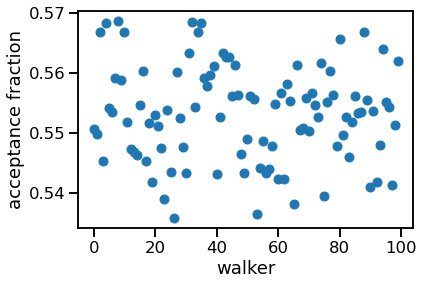

In [17]:
plt.plot(result_emcee.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")

In [18]:
if hasattr(result_emcee, "acor"):
    print("Autocorrelation time for the parameters:")
    print("----------------------------------------")
    for i, p in enumerate(result_emcee.params):
        try:
            print(f"{p} = {result_emcee.acor[i]:.3f}")
        except IndexError:
            pass

Autocorrelation time for the parameters:
----------------------------------------
r0 = 52.413
sig2 = 55.045
m = 56.615
s0 = 123.799


In [19]:
name = 'Emissivity fluctuations'
data = 'k_4'

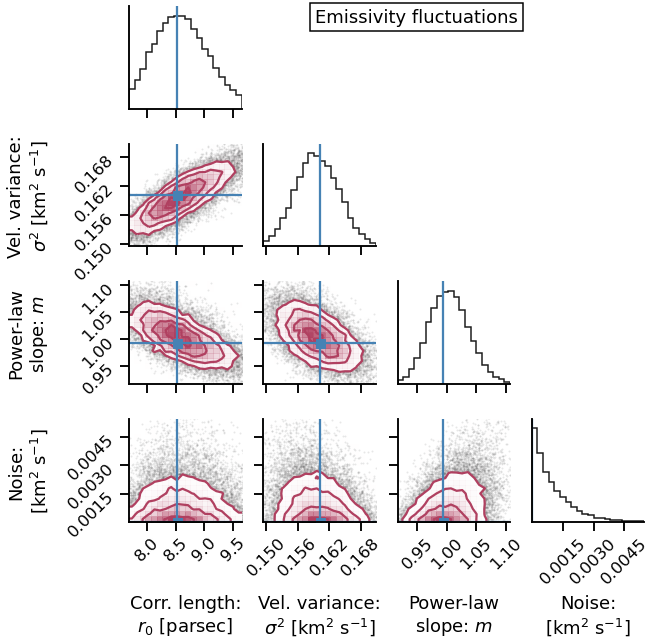

In [41]:
bplot_mod.corner_plot(
    result_emcee, result, name, data, data_ranges=[0.95, 0.99, 0.995, 0.995]
)
# data_ranges=[0.95, 0.99, 0.995, 0.995, 0.999]

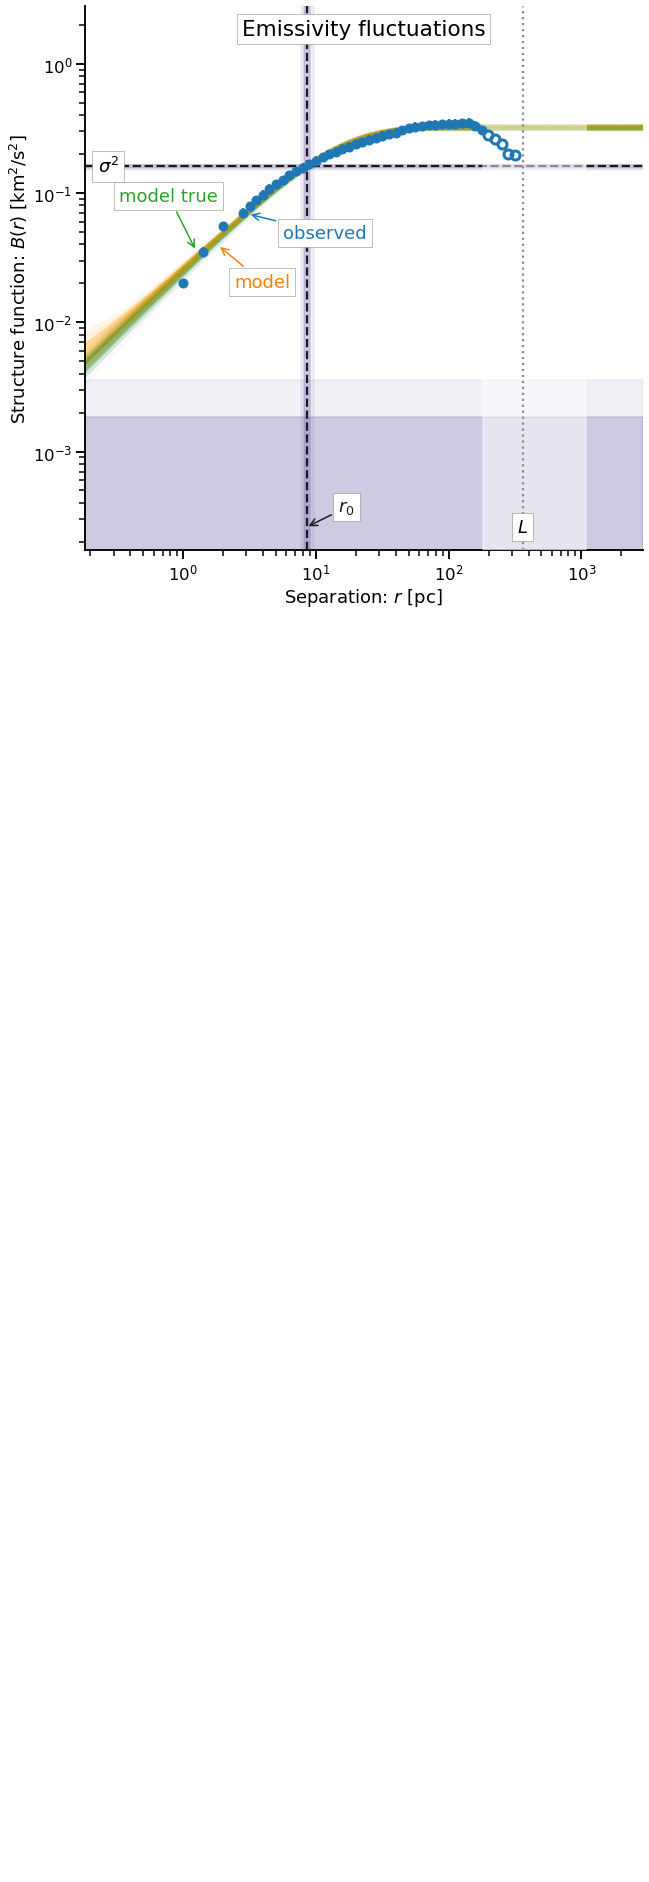

In [21]:
bplot_mod.strucfunc_plot(
    result_emcee, result, r, B, to_fit, name, data, box_size, large_scale
)

LM results

In [22]:
LM = {
    'sig2': [result.params['sig2'].value,result.params['sig2'].stderr],
    'r0': [result.params['r0'].value,result.params['r0'].stderr],
    'm' : [result.params['m'].value,result.params['m'].stderr],
    's0': [result.params['s0'].value,result.params['s0'].stderr],
    'noise' : [result.params['noise'].value,result.params['noise'].stderr]
}

In [23]:
LM

{'sig2': [0.16021608052445682, 0.005144777457865976],
 'r0': [8.53025982831275, 0.4215949750075748],
 'm': [0.9925814331073305, 0.06865939735160688],
 's0': [0.0, 0],
 'noise': [9.27315691703622e-15, 8.712081375727038e-05]}

MCMC results

In [24]:
MCMC = {
    'sig2': [result_emcee.params['sig2'].value,result_emcee.params['sig2'].stderr],
    'r0': [result_emcee.params['r0'].value,result_emcee.params['r0'].stderr],
    'm' : [result_emcee.params['m'].value,result_emcee.params['m'].stderr],
    's0': [result_emcee.params['s0'].value,result_emcee.params['s0'].stderr],
    'noise' : [result_emcee.params['noise'].value,result_emcee.params['noise'].stderr]
}

In [25]:
MCMC

{'sig2': [0.1596419283247594, 0.004164177401218674],
 'r0': [8.581042208938609, 0.5011011340476248],
 'm': [1.0031304807012467, 0.03383368524799113],
 's0': [0.0, None],
 'noise': [0.0007001517673747599, 0.0008439301071715096]}

MCMC 2 sigma confidence interval

In [26]:
sig2s2 = np.percentile(result_emcee.flatchain['sig2'],[2.5, 97.5])
r0s2 = np.percentile(result_emcee.flatchain['r0'],[2.5, 97.5])
ms2 = np.percentile(result_emcee.flatchain['m'],[2.5, 97.5])
#s0s2 = np.percentile(result_emcee.flatchain['s0'],[2.5, 97.5])
b0s2 = np.percentile(result_emcee.flatchain['noise'],[2.5, 97.5])

In [27]:
sig2s2p = sig2s2[1]-result.params['sig2'].value
sig2s2m = result.params['sig2'].value-sig2s2[0]

r0s2p = r0s2[1]-result.params['r0'].value
r0s2m = result.params['r0'].value-r0s2[0]

ms2p = ms2[1]-result.params['m'].value
ms2m = result.params['m'].value-ms2[0]

#s0s2p = s0s2[1]-result.params['s0'].value
#s0s2m = result.params['s0'].value-s0s2[0]
s0s2p = 0
s0s2m = 0

b0s2p = b0s2[1]-result.params['noise'].value
b0s2m = result.params['noise'].value-b0s2[0]

MCMC 1 sigma confidence interval

In [28]:
sig2s1 = np.percentile(result_emcee.flatchain['sig2'],[16, 85])
r0s1 = np.percentile(result_emcee.flatchain['r0'],[16, 85])
ms1 = np.percentile(result_emcee.flatchain['m'],[16, 85])
#s0s1 = np.percentile(result_emcee.flatchain['s0'],[16, 85])
s0s1 = 0
b0s1 = np.percentile(result_emcee.flatchain['noise'],[16, 85])

In [29]:
sig2s1p = sig2s1[1]-result.params['sig2'].value
sig2s1m = result.params['sig2'].value-sig2s1[0]

r0s1p = r0s1[1]-result.params['r0'].value
r0s1m = result.params['r0'].value-r0s1[0]

ms1p = ms1[1]-result.params['m'].value
ms1m = result.params['m'].value-ms1[0]

#s0s1p = s0s1[1]-result.params['s0'].value
#s0s1m = result.params['s0'].value-s0s1[0]
s0s1p = 0
s0s1m = 0

b0s1p = b0s1[1]-result.params['noise'].value
b0s1m = result.params['noise'].value-b0s1[0]

LM + MCMC 2 sigma

In [30]:
results_2sig = {
    'sig2': [result.params['sig2'].value,sig2s2p,sig2s2m],
    'r0': [result.params['r0'].value,r0s2p,r0s2m],
    'm' : [result.params['m'].value,ms2p,ms2m],
    's0': [result.params['s0'].value,s0s2p,s0s2m],
    'noise' : [result.params['noise'].value,b0s2p,b0s2m] 
    
}

In [31]:
results_2sig

{'sig2': [0.16021608052445682, 0.007819594202585711, 0.00844434124788998],
 'r0': [8.53025982831275, 1.1249323123278572, 0.8447368284559165],
 'm': [0.9925814331073305, 0.08295541854524957, 0.05156100107554529],
 's0': [0.0, 0, 0],
 'noise': [9.27315691703622e-15, 0.003592756114222587, -7.154668718237214e-06]}

In [32]:
results_1sig = {
    'sig2': [result.params['sig2'].value,sig2s1p,sig2s1m],
    'r0': [result.params['r0'].value,r0s1p,r0s1m],
    'm' : [result.params['m'].value,ms1p,ms1m],
    's0': [result.params['s0'].value,s0s1p,s0s1m],
    'noise' : [result.params['noise'].value,b0s1p,b0s1m] 
    
}

In [33]:
results_1sig

{'sig2': [0.16021608052445682, 0.003858047617678828, 0.004596754846075052],
 'r0': [8.53025982831275, 0.5919207648942368, 0.4268458483640032],
 'm': [0.9925814331073305, 0.04692734146019528, 0.0219838496657363],
 's0': [0.0, 0, 0],
 'noise': [9.27315691703622e-15,
  0.0019014912034989754,
  -0.00016050899305694051]}

Previous SF results and obs

In [34]:
#observations ={
#    'sb':data_in['VF']['sb'],
#    'vv':data_in['VF']['vv'],
#    'ss':data_in['VF']['ss']   
#}

In [35]:
#properties = {
#    'pix' : data_in['pix'],
#    'pc' : data_in['pc'],
#    'box_size' : data_in['box_size']
#}

In [36]:
#fit_results = {
#    'name' : name_in,
#    'results_1sig' : results_1sig,
#    'results_2sig' : results_2sig,
#    'LM':LM,
#    'MCMC':MCMC,
#    'properties' : properties,
#    'B' : B,
#    'r' : r,
#     'preres' : data_in['results'],
#     'SFresults' : data_in['SF'],
#    'observations' : observations
   
#}

In [37]:
#class MyEncoder(json.JSONEncoder):
#    def default(self, obj):
#        if isinstance(obj, np.integer):
#            return int(obj)
#        elif isinstance(obj, np.floating):
#            return float(obj)
#        elif isinstance(obj, np.ndarray):
#            return obj.tolist()
#        else:
#            return super(MyEncoder, self).default(obj)

In [38]:
#jsonfilename =name_in +".json"
#with open(datapath_res/jsonfilename, "w") as f:
#    json.dump(fit_results, fp=f, indent=3, cls=MyEncoder)

In [39]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 81.58407402038574 seconds ---


In [40]:
!jupyter nbconvert --to script --no-prompt ci-fake-3d-maps-emissivity-fluct_m1.ipynb

[NbConvertApp] Converting notebook ci-fake-3d-maps-emissivity-fluct_m1.ipynb to script
[NbConvertApp] Writing 8380 bytes to ci-fake-3d-maps-emissivity-fluct_m1.py
